# Homework 10

In this homework, you will implement NN using PyTorch and investigate different activation functions, batch sizes, and learning rates. Use [Lecture code](https://github.com/anton-selitskiy/RIT_ML/blob/main/2024_spring/Lectures/ML23.ipynb) as refference.

Use load_planar_dataset function from the previous homework to create the data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from mlxtend.plotting import plot_decision_regions

In [3]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros(m, dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius. 4 corresponds to the number of petals
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

## 1. (2 pt) Create Dataset object.

In [4]:
x, y = load_planar_dataset()  #make_moons(n_samples=200, noise=0.1)  make_circles(n_samples=200, noise=0.1)
y = y.reshape(-1,1)
x.shape, y.shape

((400, 2), (400, 1))

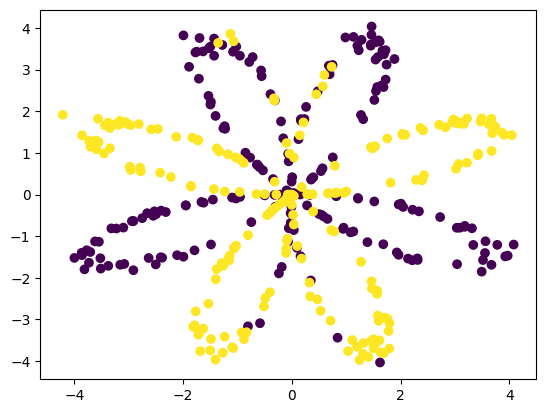

In [5]:
plt.scatter(x[:,0], x[:,1], c=y)

## 2. (1 pt) Create DataLoader object.

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# First, we will convert the dataset into a train and test set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert the train and test sets into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create the corresponding Dataset objects for train and test sets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoaders for the train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

# Let's verify the size of the datasets
(len(train_dataset), len(test_dataset))

(320, 80)

## 3. (3 pt) Construct the model
$$
hidden\_1 \to activation\_1 \to hidden\_2 \to activation\_2  
$$
Use `Sigmoid` function as activation on this step.

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
import torch.nn as nn
import torch.nn.functional as F 

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(2, 4)
        self.activation1 = nn.SiLU()
        self.hidden2 = nn.Linear(4, 1)
        self.activation2 = nn.Sigmoid()
    
    def forward(self, x):
        o = self.hidden1(x)
        o = self.activation1(o)
        o = self.hidden2(o)
        o = self.activation2(o)
        return o

model = NeuralNetwork()
model

NeuralNetwork(
  (hidden1): Linear(in_features=2, out_features=4, bias=True)
  (activation1): SiLU()
  (hidden2): Linear(in_features=4, out_features=1, bias=True)
  (activation2): Sigmoid()
)

## 4. (3 pt) Write the training loop. Use Binary cross-entropy loss. Also, you can use tqdm function to see the training progress. You can start with learning rate 0.01.

In [10]:
from torch.optim import Adam
from tqdm import tqdm

In [11]:
# Define the loss function
loss_function = nn.BCELoss()

In [12]:
# Define the optimizer
optimizer = Adam(model.parameters(), lr=0.001)

In [13]:
# Number of epochs (iterations over the entire dataset)
epochs = 10

loss_array = []

# Training loop
for epoch in tqdm(range(epochs), desc="Training Progress"):
    for inputs, labels in train_dataloader:
        # inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model.forward(inputs)
        # Compute the loss
        loss = loss_function(outputs, labels)
        loss_array.append(loss.item())
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

print("Training complete!")

Training Progress: 100%|██████████| 10/10 [00:00<00:00, 45.79it/s]

Training complete!


## 5. (2 pt) Write the prediction class to use it in plot_decision_regions function.

In [28]:
from torch.autograd import Variable
import numpy as np

class Predictor:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        # Ensure the model is in evaluation mode
        # self.model.eval()
        # Convert array to tensor
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        # Make sure to wrap the tensor in Variable, to keep track of operations on it if needed
        x = Variable(x)
        # Make predictions
        predictions = self.model.forward(x)
        # Apply threshold to obtain binary class predictions
        predicted_classes = (predictions.squeeze() > 0.5).long()
        return predicted_classes.numpy()

<Axes: >

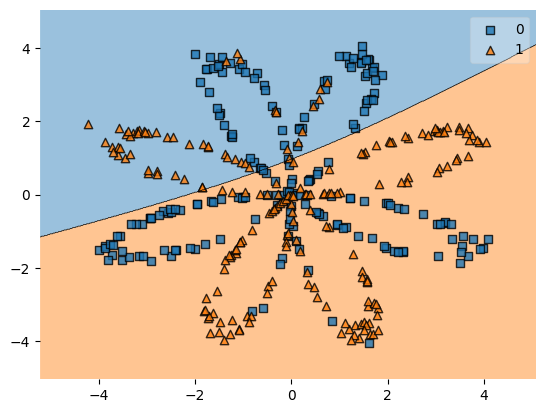

In [29]:
predictor = Predictor(model)
plot_decision_regions(x,y.reshape(-1,),predictor)

## 6. (2 pt) Plot the loss and decision boundary after the training.

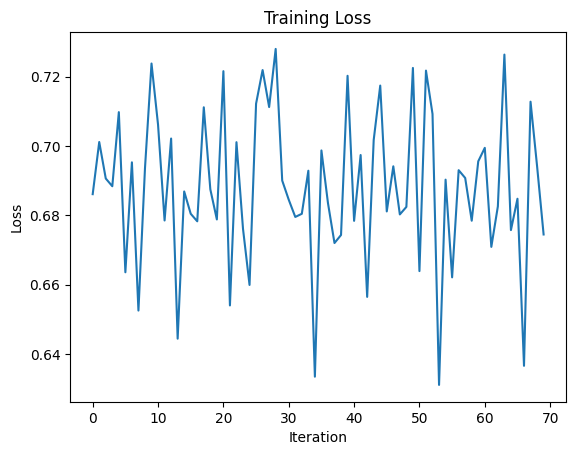

In [30]:
plt.plot(loss_array)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [31]:

with torch.no_grad():
  y_pred = model.forward(torch.tensor(x, dtype=torch.float))

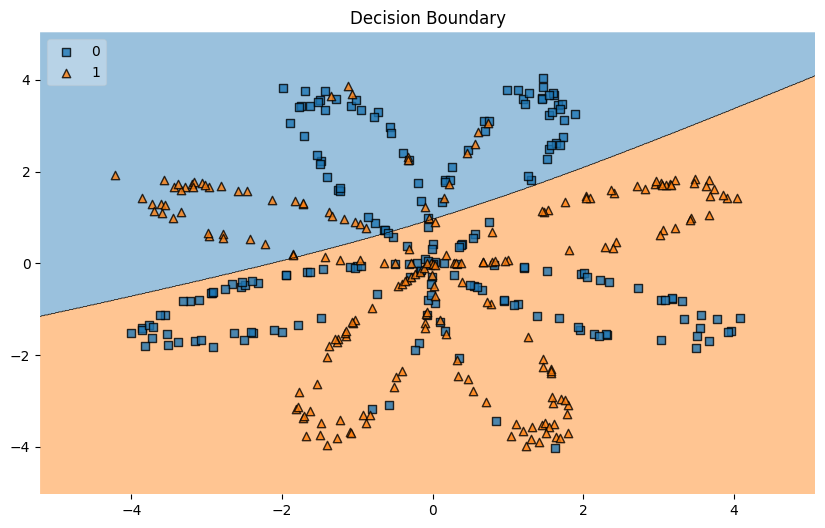

In [32]:
plt.figure(figsize=(10, 6))
plot_decision_regions(x, y.reshape(-1), clf=predictor, legend=2)
plt.title('Decision Boundary')
plt.show()

## 7. Experiments 1: Try LeakyReLU as `activation_1` with the size of `hidden_1` = 4, 5, and 10. You can reuse the same model without copying it.

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, hidden_1_size=4, activation_1_fn=F.leaky_relu):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(2, hidden_1_size)
        self.activation1_fn = activation_1_fn
        self.hidden2 = nn.Linear(hidden_1_size, 1)
        self.activation2 = nn.Sigmoid()

    def forward(self, x):
        o = self.hidden1(x)
        o = self.activation1_fn(o)
        o = self.hidden2(o)
        o = self.activation2(o)
        return o

In [52]:
# Define the LeakyReLU activation function with a small negative slope
leaky_relu = nn.LeakyReLU(0.01)

# Create model instances with different hidden_1 sizes
model_4 = NeuralNetwork(hidden_1_size=4, activation_1_fn=leaky_relu)
model_5 = NeuralNetwork(hidden_1_size=5, activation_1_fn=leaky_relu)
model_10 = NeuralNetwork(hidden_1_size=10, activation_1_fn=leaky_relu)


In [64]:
from torch.optim import Adam

optimizer_4 = Adam(model_4.parameters(), lr=0.001)
epochs = 10  

loss = []

for epoch in tqdm(range(epochs), desc="Training Progress"):
    for inputs, labels in train_dataloader:
        optimizer_4.zero_grad()
        outputs = model_4(inputs)
        batch_loss = loss_function(outputs, labels)  # Use a different variable name for batch loss
        loss.append(batch_loss.detach().item())  # Detach and store the loss value
        batch_loss.backward()
        optimizer_4.step()
        optimizer_4.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {batch_loss.item()}')

Training Progress: 100%|██████████| 10/10 [00:00<00:00, 47.17it/s]

Epoch 10, Loss: 0.6434122920036316


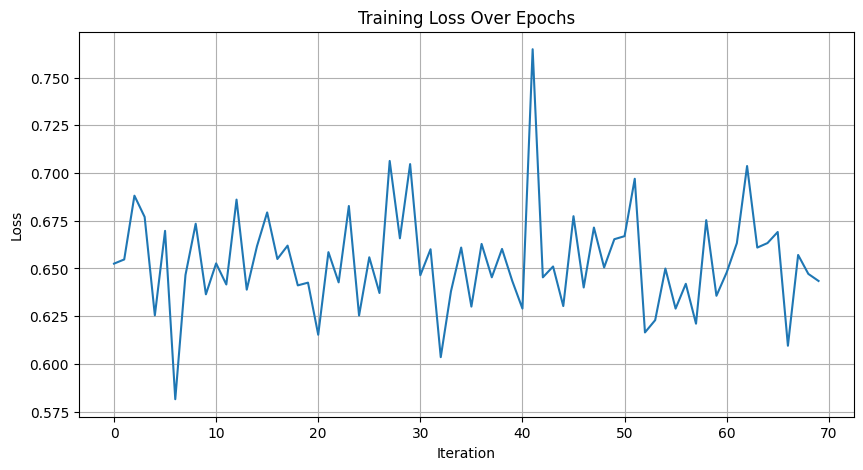

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [66]:
from torch.optim import Adam

optimizer_5 = Adam(model_5.parameters(), lr=0.001)
epochs = 10  

loss = []

for epoch in tqdm(range(epochs), desc="Training Progress"):
    for inputs, labels in train_dataloader:
        optimizer_5.zero_grad()
        outputs = model_5(inputs)
        batch_loss = loss_function(outputs, labels)  # Use a different variable name for batch loss
        loss.append(batch_loss.detach().item())  # Detach and store the loss value
        batch_loss.backward()
        optimizer_5.step()
        optimizer_5.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {batch_loss.item()}')

Training Progress: 100%|██████████| 10/10 [00:00<00:00, 58.50it/s]

Epoch 10, Loss: 0.7304676175117493


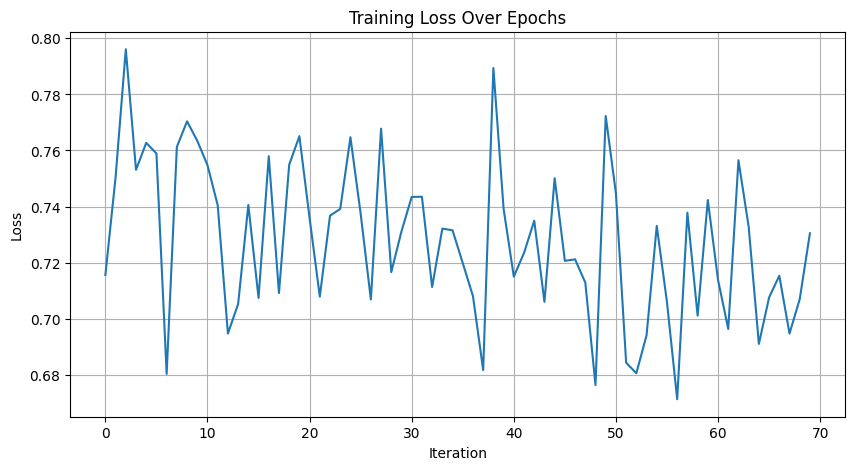

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [68]:
from torch.optim import Adam

optimizer_10 = Adam(model_10.parameters(), lr=0.001)
epochs = 10  

loss = []

for epoch in tqdm(range(epochs), desc="Training Progress"):
    for inputs, labels in train_dataloader:
        optimizer_10.zero_grad()
        outputs = model_10(inputs)
        batch_loss = loss_function(outputs, labels)  # Use a different variable name for batch loss
        loss.append(batch_loss.detach().item())  # Detach and store the loss value
        batch_loss.backward()
        optimizer_10.step()
        optimizer_10.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {batch_loss.item()}')

Training Progress: 100%|██████████| 10/10 [00:00<00:00, 50.44it/s]

Epoch 10, Loss: 0.6718345284461975


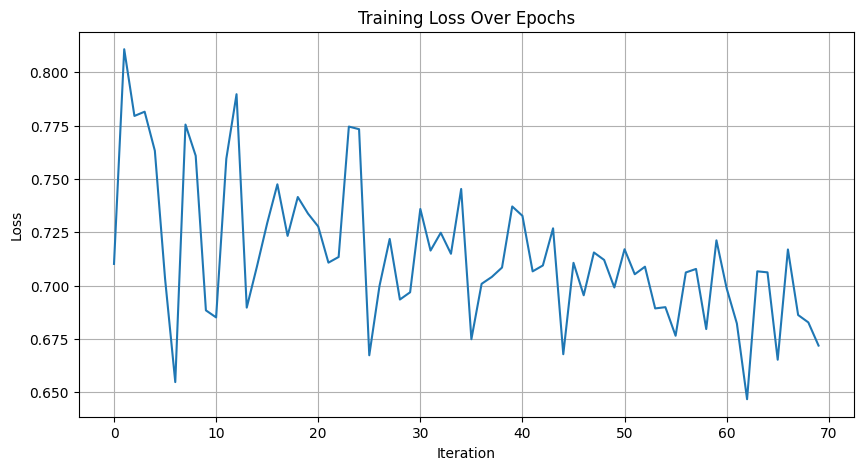

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## 8. (3 pt) Comment on the number of the straight lines with respect to the size of the hidden layer.

It appears that there's a direct relationship between the number of neurons in the first hidden layer and the complexity of the decision boundary. As the neuron count increases, the decision boundary becomes more intricate with additional segments.

## 9. Experiments 2: with the `hidden_1` layer of the size 4 try Sigmoind, ReLU, LeakyReLU, ELU, and SiLU as `activation_1`. Do this for batch sizes 4 and 50.

Sigmoid with batch size 4:
The decision boundary forms a smooth, triangular shape. At a learning rate (LR) of 0.01, it appears segmented;
At a LR of 0.001, it is uninterrupted.

Sigmoid with batch size 50:
With a LR of 0.01, it roughly bisects the points, albeit imprecisely. Smaller batches yielded improved outcomes.
At a LR of 0.001, the fit is inadequate, with many points missed.

ReLU with batch size 4:
The LR of 0.01 provides a better fit than 0.001, creating a complex, disjointed decision boundary.
With a LR of 0.001, it forms a complex boundary with several linear segments, yet it still overlooks numerous points.

ReLU with batch size 50:
A LR of 0.01 roughly divides the plane in two, indicating a poor fit.
The result at a LR of 0.001 is largely unchanged.

LeakyReLU with batch size 4:
At a LR of 0.01, the boundary delineates two separate regions, incorrectly classifying a significant cluster of points.
At a LR of 0.001, the boundary is similar, with the same misclassifications persisting.

LeakyReLU with batch size 50:
Results for LRs of 0.01 and 0.001 are akin, with the model erroneously attempting a singular, seamless boundary.

ELU with batch size 4:
The boundary is lacking at a LR of 0.01, misclassifying many points.
At a LR of 0.001, the boundary's efficacy mirrors the 0.01 LR result.

ELU with batch size 50:
Both LRs of 0.01 and 0.001 result in numerous misclassifications without significant variation in the boundary.

SiLU with batch size 4:
At a LR of 0.01, the model neglects an entire area of points.
At a LR of 0.001, the decision boundary remains unchanged.

SiLU with batch size 50:
The boundary is a single continuum at a LR of 0.01 but fails to capture many points.
At a LR of 0.001, outcomes are nearly identical.

## 10. (4 pt) Comment on the shape of the decision boundaries with respect to the activation function and the batch size. Did you adjust the learning rate? Did you try to start with small learning rate like 0.001 instead of 0.01 and if so, which worked better?


In general, the most effective decision boundary was achieved using ReLU and LeakyReLU activations in conjunction with a small batch size and learning rate.